<a href="https://colab.research.google.com/github/maxskoda/NR_autoreduce/blob/master/Nylander_RB2010526_June2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install refnx

In [ ]:
pip install numpy

In [2]:
#@title Imports
import glob
import os
import re
from ipywidgets import Layout
# import chart_studio.plotly as py
import matplotlib.pyplot as plt
import numpy as np
#import os.path
import time as tm
import pandas as pd
import pickle
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"


In [4]:
#@title Plot data
git_path = "NR_datareduction" #@param {type:"string"}
colab_path = "/content/NR_datareduction/RB2010562/" #@param {type:"string"}
file_extension = ".dat"
filename_pattern = ".*\\.txt$" #@param {type:"string"}

pth = os.path.join('https://github.com/maxskoda/',git_path)

if not os.path.exists(colab_path):
  ! git clone $pth  #NR_datareduction/'

def nr_plot(file_list):
    choices = file_list['new']
    output.clear_output(wait=True)
    fig.data = [] # remove all traces
    with output:
        for f in choices:
          X, Y, E = [], [], []
          for line in open(colab_path+f, 'r'):
            if line[0] != '#' and len(line)>1:
              values = [float(s) for s in line.split()]
              X.append(values[0])
              Y.append(values[1])
              E.append(values[2])

          fig.add_trace(
                      go.Scatter(x=X,
                  y=Y,
                  error_y=dict(
                      type='data', # value of error bar given in data coordinates
                      array=E,
                      visible=True),
                  name=f)
                  )
        fig.update_xaxes(type="log")
        fig.update_yaxes(type="log")
        fig.show()

# if filename_pattern
ff = [f for f in os.listdir(colab_path) if re.search(filename_pattern, f)]

# ff = [os.path.basename(x) for x in glob.glob(colab_path+"*IvsQ_[0..9]_[0..9]"+file_extension)]

selector = widgets.SelectMultiple(
options=sorted(ff),
# value=[ff[0]],
rows=29,
description='Workspaces',
disabled=False,
layout=Layout(valign='bottom')
)

fig = go.Figure()
fig.update_layout(
    yaxis = {'exponentformat':'power'},
    margin=dict(l=100, r=20, t=20, b=20),
    modebar= {'orientation': 'v'},
    width=1000, height=500)#, 'ticks':'inside'})

output = widgets.Output()

items = [selector, output]
box_layout = Layout(display='flex', flex_flow='row', 
                    justify_content='space-between', align_items='stretch',
                    align_content='flex-end')

display(widgets.HBox(items, leyout=box_layout))
# display(selector)
# display(output)


selector.observe(nr_plot, names='value')

In [30]:
#@title Model parameters 
path = "/content/NR_datareduction/RB2010562/" #@param {type:"string"}
D2O_run = "IvsQ_34213_34214_34215+34216.txt" #@param {type:"string"}
H2O_run = "IvsQ_34225_34226_34227+34228.txt" #@param {type:"string"}
CMSi_run = "IvsQ_34217_34218_34219+34220.txt" #@param {type:"string"}


import refnx, scipy

# the analysis module contains the curvefitting engine
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective, process_chain, Transform

# the reflect module contains functionality relevant to reflectometry
from refnx.reflect import SLD, MixedReflectModel, ReflectModel, Structure, Stack, LipidLeaflet

# the ReflectDataset object will contain the data
from refnx.dataset import ReflectDataset

def remove_negative(file):
  with open(file) as f:
    x = []
    y = []
    e = []
    dq=[]
    for line in f:
      try: 
        xx, yy, ee, dqq = line.lstrip().split()
        x.append(xx)
        y.append(yy)
        e.append(ee)
        dq.append(dqq)
      except ValueError:
        print("Some unreadable data...")
  result = (x, y, e)
  return result

if D2O_run != "":
  data_d2o = ReflectDataset(remove_negative(path+D2O_run))
  data_d2o.name = "D2O run"
if H2O_run != "":
  data_h2o = ReflectDataset(remove_negative(path+H2O_run))
  data_h2o.name = "H2O run"
if CMSi_run != "":
  data_CMSi = ReflectDataset(remove_negative(path+CMSi_run))
  data_CMSi.name = "CMSi run"

In [14]:
Si = SLD(2.07 + 0j)
SiO2 = SLD(3.47 + 0j)

# the following represent the solvent contrasts used in the experiment
d2o = SLD(6.3 + 0j)
h2o = SLD(-0.56 + 0j)
hdmix = SLD(2.07 + 0j)

# We want the `real` attribute parameter to vary in the analysis, and we want to apply
# uniform bounds. The `setp` method of a Parameter is a way of changing many aspects of
# Parameter behaviour at once.
d2o.real.setp(vary=True, bounds=(5.9, 6.36))
d2o.real.name='d2o SLD'

# Slab for oxide layer
SiO2_slab = SiO2(18, 3)
SiO2_slab.thick.setp(vary=True, bounds=(5, 30))
SiO2_slab.thick.name = 'SiO2 thickness'
SiO2_slab.rough.setp(vary=True, bounds=(3, 10))
SiO2_slab.rough.name = name='SiO2 roughness'
SiO2_slab.vfsolv.setp(0.0, vary=False, bounds=(0., 1.0))
SiO2_slab.vfsolv.name = 'SiO2 solvation'

solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(0, 15))# Slab constructed from SLD object.


In [15]:
# Parameter for the area per molecule each DMPC molecule occupies at the surface. We
# use the same area per molecule for the inner and outer leaflets.
apm = Parameter(56, 'area per molecule', vary=True, bounds=(42, 75))
apm_stack = Parameter(56, 'area per molecule in the stack', vary=True, bounds=(42, 85))

#### POPC #########
# the sum of scattering lengths for the lipid head and tail in Angstrom.
b_heads_PC = 7.0e-4
b_tails_PC = -2.68e-4

# the volume occupied by the head and tail groups in cubic Angstrom.
v_heads_PC = 331.0
v_tails_PC = 932.5
###################

#### POPG #########
# the sum of scattering lengths for the lipid head and tail in Angstrom.
b_heads_PG = 7.14e-4
b_tails_PG = -2.68e-4

# the volume occupied by the head and tail groups in cubic Angstrom.
v_heads_PG = 291
v_tails_PG = 932.5
###################

vfrac_POPC = 0.75
# the sum of scattering lengths for the lipid head and tail in Angstrom.
b_heads = Parameter(vfrac_POPC*b_heads_PC + (1 - vfrac_POPC)*b_heads_PG, 'b_heads')
b_tails = Parameter(vfrac_POPC*b_tails_PC + (1 - vfrac_POPC)*b_tails_PG, 'b_tails')

# the volume occupied by the head and tail groups in cubic Angstrom.
v_heads = Parameter(vfrac_POPC*v_heads_PC + (1 - vfrac_POPC)*v_heads_PG, 'v_heads')
v_tails = Parameter(vfrac_POPC*v_tails_PC + (1 - vfrac_POPC)*v_tails_PG, 'v_tails')

# the head and tail group thicknesses.
inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

inner_head_thickness_stack = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness_stack = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness_stack = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

# finally construct a `LipidLeaflet` object for the inner and outer leaflets.
# Note that here the inner and outer leaflets use the same area per molecule,
# same tail thickness, etc, but this is not necessary if the inner and outer
# leaflets are different.
inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)

# we reverse the monolayer for the outer leaflet because the tail groups face upwards
outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, outer_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

inner_leaflet_stack = LipidLeaflet(apm_stack,
                             b_heads, v_heads, inner_head_thickness_stack,
                             b_tails, v_tails, tail_thickness_stack,
                             3, 3)

# we reverse the monolayer for the outer leaflet because the tail groups face upwards
outer_leaflet_stack = LipidLeaflet(apm_stack,
                             b_heads, v_heads, outer_head_thickness_stack,
                             b_tails, v_tails, tail_thickness_stack,
                             3, 0, reverse_monolayer=True)

In [33]:
# assemble the structures:
s_d2o   = Si | SiO2_slab | inner_leaflet | outer_leaflet | d2o(0, solv_roughness)
s_hdmix = Si | SiO2_slab | inner_leaflet | outer_leaflet | hdmix(0, solv_roughness)
s_h2o   = Si | SiO2_slab | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

In [40]:
model_d2o = ReflectModel(s_d2o, bkg=3e-7, dq=3.5)
model_h2o = ReflectModel(s_h2o, bkg=3e-7, dq=3.5)
model_cmsi = ReflectModel(s_hdmix, bkg=3e-7, dq=3.5)

In [41]:
objective_d2o = Objective(model_d2o, data_d2o)
objective_hdmix = Objective(model_cmsi, data_CMSi)
objective_h2o = Objective(model_h2o, data_h2o)

global_objective = GlobalObjective([objective_d2o, objective_hdmix, objective_h2o])

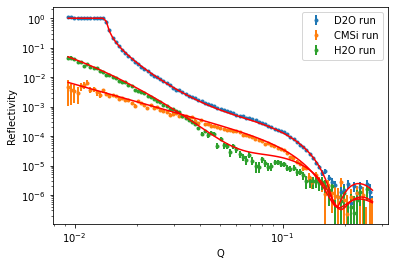

In [42]:
global_objective.plot()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [ ]:
fitter = CurveFitter(global_objective)
fitter.fit('least_squares')

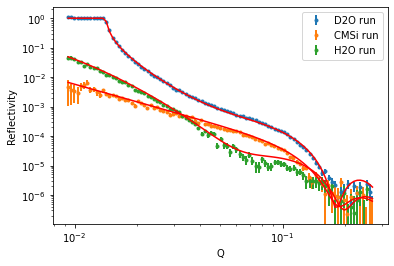

In [44]:
global_objective.plot()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.legend();

In [29]:
print(global_objective.varying_parameters())
# output_df

________________________________________________________________________________
Parameters:      None      
<Parameter:'SiO2 thickness', value=17.4127 +/- 31.6 , bounds=[5.0, 30.0]>
<Parameter:'SiO2 roughness', value=5.71447 +/- 8.42 , bounds=[3.0, 10.0]>
<Parameter:'area per molecule', value=65.6922  +/- 23  , bounds=[42.0, 75.0]>
<Parameter:'inner_head_thickness', value=6.442 +/- 17.6 , bounds=[4.0, 11.0]>
<Parameter:'tail_thickness', value=16.1771 +/- 5.41 , bounds=[10.0, 17.0]>
<Parameter:'outer_head_thickness', value=6.37322 +/- 9.37 , bounds=[4.0, 11.0]>
<Parameter:   'd2o SLD'   , value=5.96946 +/- 0.00424, bounds=[5.9, 6.36]>
<Parameter:'bilayer/solvent roughness', value=8.64304  +/- 5.4 , bounds=[0.0, 15.0]>
